In [ ]:
import tensorflow as tf

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU is available:", gpus)
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("❌ No GPU detected. Will use CPU.")

✅ GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
replace Flower Classification V2/V2/TFRecords/Test/Aster_1.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
from tensorflow.keras.applications import MobileNetV3Large

In [ ]:
### ========== IMPORTS AND GPU SETUP ==========
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, MobileNetV2, MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("\u2705 GPU is available:", gpus)
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("\u274C No GPU detected. Using CPU.")


### ========== DATA PREPARATION ==========
data_dir = "/content/Flower Classification V2/V2/Training Data"
img_height, img_width = 96, 96
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                             shear_range=0.1, zoom_range=0.2, horizontal_flip=True)

train_ds = datagen.flow_from_directory(data_dir, target_size=(img_height, img_width),
                                       batch_size=batch_size, class_mode='categorical',
                                       subset='training', shuffle=True)

test_ds = datagen.flow_from_directory(data_dir, target_size=(img_height, img_width),
                                      batch_size=batch_size, class_mode='categorical',
                                      subset='validation', shuffle=False)

num_classes = train_ds.num_classes


### ========== MODEL DEFINITIONS ==========
def build_student_model(input_shape=(96, 96, 3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_teacher_model(base_model_fn, input_shape=(96, 96, 3), num_classes=10):
    base = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base.layers[:-4]:
      layer.trainable = False
    for layer in base.layers[-4:]:
      layer.trainable = True
    inputs = Input(shape=input_shape)
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)


### ========== DISTILLATION CLASSES ==========
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher, temperature=3.0, alpha=0.5):
        super().__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.student_loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.distillation_loss_fn = tf.keras.losses.KLDivergence()
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.CategoricalAccuracy()

    def compile(self, optimizer):
        super().compile()
        if isinstance(optimizer, str):
            self.optimizer = tf.keras.optimizers.get(optimizer)
        else:
            self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        teacher_preds = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_preds = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_preds)
            distill_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_preds / self.temperature, axis=1),
                tf.nn.softmax(student_preds / self.temperature, axis=1))
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(y, student_preds)
        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}

    def test_step(self, data):
        x, y = data
        preds = self.student(x, training=False)
        self.acc_tracker.update_state(y, preds)
        return {"accuracy": self.acc_tracker.result()}

class MultiTeacherDistiller(Distiller):
    def __init__(self, student, teacher1, teacher2, temperature=3.0, alpha=0.5):
        super().__init__(student, teacher1, temperature, alpha)
        self.teacher2 = teacher2

    def train_step(self, data):
        x, y = data
        t1 = self.teacher(x, training=False)
        t2 = self.teacher2(x, training=False)
        avg = (t1 + t2) / 2.0
        with tf.GradientTape() as tape:
            preds = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, preds)
            distill_loss = self.distillation_loss_fn(
                tf.nn.softmax(avg / self.temperature, axis=1),
                tf.nn.softmax(preds / self.temperature, axis=1))
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(y, preds)
        return {"loss": self.loss_tracker.result(), "accuracy": self.acc_tracker.result()}



### ========== TRAINING AND EVALUATION ==========


✅ GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 12000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [21]:
# Build models
teacher_mobilenet2 = build_teacher_model(MobileNetV2, num_classes=num_classes)
teacher_mobilenet3 = build_teacher_model(MobileNetV3Small, num_classes=num_classes)

models_to_train = {
    "student_baseline": build_student_model(num_classes=num_classes),
    "teacher_mobilenet2": teacher_mobilenet2,
    "teacher_mobilenet3": teacher_mobilenet3,
    "student_single": build_student_model(num_classes=num_classes),
    "student_multi": build_student_model(num_classes=num_classes),
}

# Compile and train
histories = {}
eval_results = {}

for name, model in models_to_train.items():
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if "teacher" in name or "student_baseline" in name:
        cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
        histories[name] = model.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=[cb])
        # model.load_weights(...) removed due to restore_best_weights=True
        eval_results[name] = dict(zip(['loss', 'acc'], model.evaluate(test_ds, verbose=0)))


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.3635 - loss: 1.8365 - val_accuracy: 0.4843 - val_loss: 1.4815
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.5323 - loss: 1.3619 - val_accuracy: 0.5997 - val_loss: 1.2442
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - accuracy: 0.5856 - loss: 1.2048 - val_accuracy: 0.5980 - val_loss: 1.1934
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 124ms/step - accuracy: 0.6231 - loss: 1.1132 - val_accuracy: 0.6250 - val_loss: 1.1832
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6716 - loss: 0.9866 - val_accuracy: 0.6237 - val_loss: 1.2195
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.6943 - loss: 0.9133 - val_accuracy: 0.6583 - val_loss: 1.0596
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.7177 - loss: 0.8536 - val_accuracy: 0.6460 - val_loss: 1.1408
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 125ms/step - accuracy: 0.7375 - loss: 0

In [22]:

# Distill from single teacher
distill_mobilenet2 = Distiller(student=models_to_train["student_single"], teacher=teacher_mobilenet2)
distill_mobilenet2.compile(optimizer='adam')
distill_mobilenet2.fit(train_ds, validation_data=test_ds, epochs=30,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)])
# Removed: restore_best_weights=True handles loading best weights
eval_results["student_single"] = dict(zip(['loss', 'acc'], models_to_train["student_single"].evaluate(test_ds, verbose=0)))

# Distill from both teachers
distill_multi = MultiTeacherDistiller(student=models_to_train["student_multi"], teacher1=teacher_mobilenet2, teacher2=teacher_mobilenet3)
distill_multi.compile(optimizer='adam')
distill_multi.fit(train_ds, validation_data=test_ds, epochs=30,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)])
# Removed: restore_best_weights=True handles loading best weights
eval_results["student_multi"] = dict(zip(['loss', 'acc'], models_to_train["student_multi"].evaluate(test_ds, verbose=0)))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.3188 - loss: 0.9954 - val_accuracy: 0.5157
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - accuracy: 0.5302 - loss: 0.6857 - val_accuracy: 0.5657
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 130ms/step - accuracy: 0.5862 - loss: 0.6103 - val_accuracy: 0.5857
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - accuracy: 0.6237 - loss: 0.5603 - val_accuracy: 0.5820
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 129ms/step - accuracy: 0.6522 - loss: 0.5278 - val_accuracy: 0.6203
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.6917 - loss: 0.4655 - val_accuracy: 0.6337
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - accuracy: 0.7118 - loss: 0.4374 - val_accuracy: 0.6480
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - accuracy: 0.7380 - loss: 0.3875 - val_accuracy: 0.6567
Epoch 9/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.7579 - loss: 0.3666 - val_accuracy:

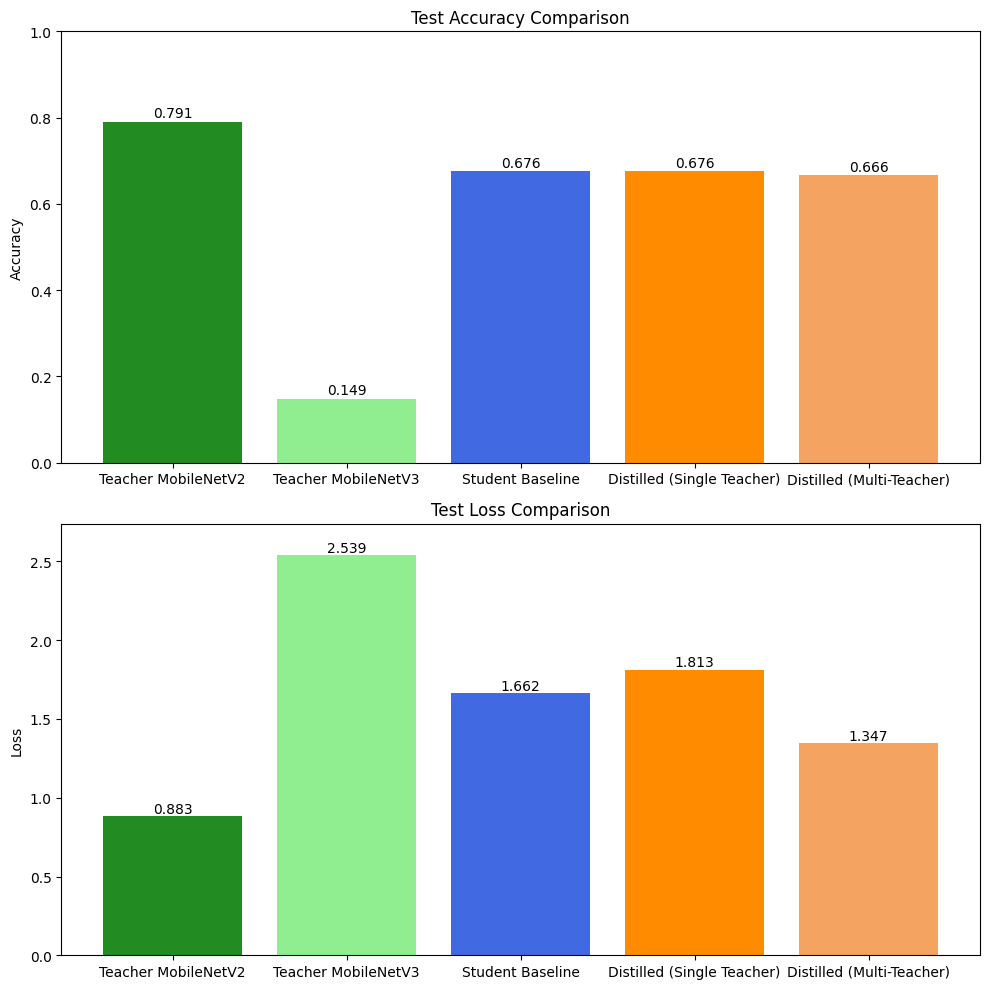

In [24]:

### ========== PLOT RESULTS ==========
labels = [
    "Teacher MobileNetV2", "Teacher MobileNetV3", "Student Baseline",
    "Distilled (Single Teacher)", "Distilled (Multi-Teacher)"
]

plot_order = ["teacher_mobilenet2", "teacher_mobilenet3", "student_baseline", "student_single", "student_multi"]
accs = [eval_results[k]['acc'] for k in plot_order]
losses = [eval_results[k]['loss'] for k in plot_order]
colors = ['forestgreen', 'lightgreen', 'royalblue', 'darkorange', 'sandybrown']

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].bar(labels, accs, color=colors)
axs[0].set_ylim(0, 1)
axs[0].set_title('Test Accuracy Comparison')
axs[0].set_ylabel('Accuracy')
for i, val in enumerate(accs): axs[0].text(i, val + 0.01, f"{val:.3f}", ha='center')

axs[1].bar(labels, losses, color=colors)
axs[1].set_ylim(0, max(losses) + 0.2)
axs[1].set_title('Test Loss Comparison')
axs[1].set_ylabel('Loss')
for i, val in enumerate(losses): axs[1].text(i, val + 0.02, f"{val:.3f}", ha='center')

plt.tight_layout()
plt.show()


In [ ]:
teacher_mobilenet3l = build_teacher_model(MobileNetV3Large, num_classes=num_classes)

models_to_train = {
    "teacher_mobilenet3l": teacher_mobilenet3l,
    "student_multil": build_student_model(num_classes=num_classes),
}

for name, model in models_to_train.items():
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    if "teacher" in name or "student_baseline" in name:
        cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
        histories[name] = model.fit(train_ds, validation_data=test_ds, epochs=30, callbacks=[cb])
        # model.load_weights(...) removed due to restore_best_weights=True
        eval_results[name] = dict(zip(['loss', 'acc'], model.evaluate(test_ds, verbose=0)))


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 67s 146ms/step - accuracy: 0.2101 - loss: 2.2340 - val_accuracy: 0.0950 - val_loss: 2.4191
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.3017 - loss: 1.9822 - val_accuracy: 0.1377 - val_loss: 2.3299
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 47s 124ms/step - accuracy: 0.3328 - loss: 1.9170 - val_accuracy: 0.1750 - val_loss: 2.3341
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.3482 - loss: 1.8840 - val_accuracy: 0.1520 - val_loss: 2.3203
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 121ms/step - accuracy: 0.3681 - loss: 1.8495 - val_accuracy: 0.1347 - val_loss: 2.2532
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 123ms/step - accuracy: 0.3658 - loss: 1.8236 - val_accuracy: 0.1623 - val_loss: 2.4829
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 46s 122ms/step - accuracy: 0.3808 - loss: 1.8134 - val_accuracy: 0.1400 - val_loss: 3.6391
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 128ms/step - accuracy: 0.3879 - loss: 1

In [ ]:

# Distill from both teachers
distill_multil = MultiTeacherDistiller(student=models_to_train["student_multil"], teacher1=teacher_mobilenet2, teacher2=teacher_mobilenet3l)
distill_multil.compile(optimizer='adam')
distill_multil.fit(train_ds, validation_data=test_ds, epochs=30,
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)])
# Removed: restore_best_weights=True handles loading best weights
eval_results["student_multil"] = dict(zip(['loss', 'acc'], models_to_train["student_multil"].evaluate(test_ds, verbose=0)))

In [ ]:

### ========== PLOT RESULTS ==========
labels = [
    "Teacher MobileNetV2", "Teacher MobileNetV3L", "Student Baseline",
    "Distilled (Single Teacher)", "Distilled (Multi-Teacher)"
]

plot_order = ["teacher_mobilenet2", "teacher_mobilenet3l", "student_baseline", "student_single", "student_multi"]
accs = [eval_results[k]['acc'] for k in plot_order]
losses = [eval_results[k]['loss'] for k in plot_order]
colors = ['forestgreen', 'lightgreen', 'royalblue', 'darkorange', 'sandybrown']

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].bar(labels, accs, color=colors)
axs[0].set_ylim(0, 1)
axs[0].set_title('Test Accuracy Comparison')
axs[0].set_ylabel('Accuracy')
for i, val in enumerate(accs): axs[0].text(i, val + 0.01, f"{val:.3f}", ha='center')

axs[1].bar(labels, losses, color=colors)
axs[1].set_ylim(0, max(losses) + 0.2)
axs[1].set_title('Test Loss Comparison')
axs[1].set_ylabel('Loss')
for i, val in enumerate(losses): axs[1].text(i, val + 0.02, f"{val:.3f}", ha='center')

plt.tight_layout()
plt.show()
